In [1]:
'''
# notes 
df["firstname"] = df["Name"].apply(lambda x : x.split(",")[0]) # extract firstname
df["salutation"] = df["Name"].apply(lambda x:x.split(",")[-1].split(".")[0]) # extract salutation e.g: mr,mrs,dr,...
df["lastname"] = df["Name"].apply(lambda x:x.split(",")[-1].split(".")[-1]) # extract last name
df.drop("Name", 1, inplace=True) # already processed
df.head()

df.dropna(subset=["Embarked"], inplace=True)

sns.countplot(x="Sex", hue="Survived", data=df)

#1-hot-encode Pclass
pclass_encoded = pd.get_dummies(df["Pclass"])
pclass_encoded.head()

#sns.boxplot(y="Age",x="SibSp",data=df)
#sns.heatmap(df.corr())
'''
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # disable gpu
# Kaggle setting:
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

import numpy as np
import pandas as pd  
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping # controlling loss

os.environ['PYTHONHASHSEED'] = '0' # Constant python seed
np.random.seed(111) # Constant numpy seed
tf.random.set_seed(111) # Constant tensorflow seed

In [2]:
df = pd.read_csv("train.csv")
print(f"Dataset Shape: {df.shape} \n")
print(df.info())
df.head()

Dataset Shape: (891, 12) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
for col in df.columns[1:]:
    print(df[col].value_counts())
    print("----------------------")

df.drop("Ticket", 1, inplace=True) # lots of randomness. seems has no relation to other cols. too many uniques to be 1-hot-encoded
df.drop("Name", 1, inplace=True) # too many uniques to be 1-hot-encoded. can be used in future modellings

df.describe().T # stats of numerical fields

0    549
1    342
Name: Survived, dtype: int64
----------------------
3    491
1    216
2    184
Name: Pclass, dtype: int64
----------------------
Leitch, Miss. Jessie Wills                        1
Pinsky, Mrs. (Rosa)                               1
Morley, Mr. Henry Samuel ("Mr Henry Marshall")    1
Kalvik, Mr. Johannes Halvorsen                    1
West, Mr. Edwy Arthur                             1
                                                 ..
Stranden, Mr. Juho                                1
Hansen, Mr. Henry Damsgaard                       1
Sadlier, Mr. Matthew                              1
Nosworthy, Mr. Richard Cater                      1
Bissette, Miss. Amelia                            1
Name: Name, Length: 891, dtype: int64
----------------------
male      577
female    314
Name: Sex, dtype: int64
----------------------
24.00    30
22.00    27
18.00    26
19.00    25
30.00    25
         ..
55.50     1
70.50     1
66.00     1
23.50     1
0.42      1
Name: Age, Le

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [4]:
# Missing values treatment:
print("% missings in cols:")
print(df.isnull().sum()[df.isnull().sum()>0]/df.shape[0]*100)
print("----------------------")

# 1- drop Cabin as majority of column is empty. Also it seems there's no way to retrieve NAs
df.drop("Cabin", 1, inplace=True) # 
print("droped column Cabin ")

# 2- fill NA of Embarked with its mode
df["Embarked"] = df["Embarked"].fillna(value=df["Embarked"].mode()[0])
print("replaced NA of Embarked with mode")

'''
# 3- fill NA of Age with its average
df["Age"] = df["Age"].fillna(value=df["Age"].mead())
'''
df["Age"][df["SibSp"]==0]=df["Age"][df["SibSp"]==0].fillna(value=df["Age"][df["SibSp"]==0].mean())
df["Age"][df["SibSp"]==1]=df["Age"][df["SibSp"]==1].fillna(value=df["Age"][df["SibSp"]==1].mean())
df["Age"][df["SibSp"]==2]=df["Age"][df["SibSp"]==2].fillna(value=df["Age"][df["SibSp"]==2].mean())
df["Age"][df["SibSp"]==3]=df["Age"][df["SibSp"]==3].fillna(value=df["Age"][df["SibSp"]==3].mean())
df["Age"][df["SibSp"]==4]=df["Age"][df["SibSp"]==4].fillna(value=df["Age"][df["SibSp"]==4].mean())
df["Age"][df["SibSp"]==5]=df["Age"][df["SibSp"]==5].fillna(value=df["Age"][df["SibSp"]==5].mean())
df["Age"] = df["Age"].fillna(value=df["Age"].mean())
print("replaced NA of Age with mean")
print("----------------------")


print("% missings in cols:")
print(round(df.isnull().sum()[df.isnull().sum()>0]/df.shape[0]*100),2)
print(f"Dataset Shape: {df.shape} \n")
df.head()

% missings in cols:
Age         19.865320
Cabin       77.104377
Embarked     0.224467
dtype: float64
----------------------
droped column Cabin 
replaced NA of Embarked with mode
replaced NA of Age with mean
----------------------
% missings in cols:
Series([], dtype: float64) 2
Dataset Shape: (891, 9) 



/Users/rezanaghshineh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/rezanaghshineh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/rezanaghshineh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/rezanaghshineh/opt/anaconda3/lib/

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [5]:
# 1-hot-encoding:
# Sex
df["Sex"] = df["Sex"].map({"male":1, "female":0}) # male = 1 / female = 0

# Embarked
embarked_encoded = pd.get_dummies(df["Embarked"])

# Pclass
pclass_encoded = pd.get_dummies(df["Pclass"])

df.drop(["Embarked","Pclass"],axis=1,inplace=True) # drop uncoded cols
df = pd.concat([df,embarked_encoded,pclass_encoded],axis=1) # concat encoded ones

df.to_csv('df_v1.csv',index=False)
print(f"Dataset Shape: {df.shape} \n")
df.head()

Dataset Shape: (891, 13) 



,PassengerId,Survived,Sex,Age,SibSp,Parch,Fare,C,Q,S,1,2,3
0,1,0,1,22.0,1,0,7.2500,0,0,1,0,0,1
1,2,1,0,38.0,1,0,71.2833,1,0,0,1,0,0
2,3,1,0,26.0,0,0,7.9250,0,0,1,0,0,1
3,4,1,0,35.0,1,0,53.1000,0,0,1,1,0,0
4,5,0,1,35.0,0,0,8.0500,0,0,1,0,0,1


In [6]:
#modeling:
df_v1 = pd.read_csv("df_v1.csv")

# Features & Labels
X1 = df_v1.iloc[:,2:].values
y1 = df_v1["Survived"].values

# train/test split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.1
                                                        , random_state=42
                                                       )
print(f"shapes: X1_train:{X1_train.shape}, X1_test:{X1_test.shape}, y1_train:{y1_train.shape}, y1_test:{y1_test.shape}")

# scaling
scaler = MinMaxScaler()
scaler.fit(X1_train)
X1_train = scaler.transform(X1_train)
X1_test = scaler.transform(X1_test)

# model
def build_model():
    model = Sequential()
    
    model.add(Dense(units=5, activation='relu'))
    model.add(Dropout(0.5))
     
    model.add(Dense(units=5, activation='relu'))
    model.add(Dropout(0.5))
   
    '''
    model.add(Dense(units=25, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(units=17, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(units=9, activation='relu'))
    model.add(Dropout(0.5))
    '''
    
    model.add(Dense(units=1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = build_model()

# early stopping callback
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=32)

shapes: X1_train:(801, 11), X1_test:(90, 11), y1_train:(801,), y1_test:(90,)


In [7]:
model.fit(x=X1_train, y=y1_train,epochs=1000, validation_data=(X1_test,y1_test),
                   callbacks=[early_stop]
)

Train on 801 samples, validate on 90 samples
Epoch 1/1000
801/801 [==============================] - 2s 3ms/sample - loss: 0.8109 - accuracy: 0.5518 - val_loss: 0.7379 - val_accuracy: 0.4333
Epoch 2/1000
801/801 [==============================] - 0s 184us/sample - loss: 0.7682 - accuracy: 0.6142 - val_loss: 0.7139 - val_accuracy: 0.4667
Epoch 3/1000
801/801 [==============================] - 0s 347us/sample - loss: 0.7278 - accuracy: 0.6080 - val_loss: 0.6921 - val_accuracy: 0.4889
Epoch 4/1000
801/801 [==============================] - 0s 463us/sample - loss: 0.7100 - accuracy: 0.6142 - val_loss: 0.6751 - val_accuracy: 0.7333
Epoch 5/1000
801/801 [==============================] - 0s 317us/sample - loss: 0.6849 - accuracy: 0.6479 - val_loss: 0.6629 - val_accuracy: 0.7889
Epoch 6/1000
801/801 [==============================] - 1s 628us/sample - loss: 0.6853 - accuracy: 0.6617 - val_loss: 0.6553 - val_accuracy: 0.7889
Epoch 7/1000
801/801 [==============================] - 0s 274us/samp

Max. val_accuracy:  0.8444444537162781


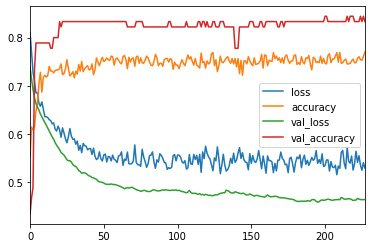

In [8]:
model_loss_df = pd.DataFrame(model.history.history)
print("Max. val_accuracy: ", model_loss_df["val_accuracy"].max())
model_loss_df.plot()

In [9]:
'''
test_df = pd.read_csv("test.csv")
test_df.drop("Ticket", 1, inplace=True)
test_df.drop("Name", 1, inplace=True)
test_df.drop("Cabin", 1, inplace=True)
test_df["Embarked"] = test_df["Embarked"].fillna(value=test_df["Embarked"].mode()[0])
#test_df["Age"] = test_df["Age"].fillna(value=test_df["Age"].mean())
test_df["Sex"] = test_df["Sex"].map({"male":1, "female":0})
test_embarked_encoded = pd.get_dummies(test_df["Embarked"])
test_pclass_encoded = pd.get_dummies(test_df["Pclass"])
test_df.drop(["Embarked","Pclass"],axis=1,inplace=True)
test_df = pd.concat([test_df,test_embarked_encoded,test_pclass_encoded],axis=1)
print(f"test_df Shape: {df.shape} \n")

test = scaler.transform(test_df.iloc[:,1:])
preds = pd.DataFrame(model.predict(test))
preds.columns = ["Survived"]
preds["Survived"] = preds["Survived"].apply(lambda x: 1 if (x>0.5) else 0)

submit = pd.concat([test_df["PassengerId"],preds],1)
submit.to_csv('submit.csv',index=False)
submit.head()

'''

'\ntest_df = pd.read_csv("test.csv")\ntest_df.drop("Ticket", 1, inplace=True)\ntest_df.drop("Name", 1, inplace=True)\ntest_df.drop("Cabin", 1, inplace=True)\ntest_df["Embarked"] = test_df["Embarked"].fillna(value=test_df["Embarked"].mode()[0])\n#test_df["Age"] = test_df["Age"].fillna(value=test_df["Age"].mean())\ntest_df["Sex"] = test_df["Sex"].map({"male":1, "female":0})\ntest_embarked_encoded = pd.get_dummies(test_df["Embarked"])\ntest_pclass_encoded = pd.get_dummies(test_df["Pclass"])\ntest_df.drop(["Embarked","Pclass"],axis=1,inplace=True)\ntest_df = pd.concat([test_df,test_embarked_encoded,test_pclass_encoded],axis=1)\nprint(f"test_df Shape: {df.shape} \n")\n\ntest = scaler.transform(test_df.iloc[:,1:])\npreds = pd.DataFrame(model.predict(test))\npreds.columns = ["Survived"]\npreds["Survived"] = preds["Survived"].apply(lambda x: 1 if (x>0.5) else 0)\n\nsubmit = pd.concat([test_df["PassengerId"],preds],1)\nsubmit.to_csv(\'submit.csv\',index=False)\nsubmit.head()\n\n'